In [ ]:
!pip install joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_App-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Mounted at /content/drive


In [ ]:
import joblib

In [ ]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Quest22_SMQ890,Quest22_SMQ900,Quest21_SLQ300,Quest21_SLQ330,Quest21_SLD012,Dieta1_DR1TKCAL,Dieta1_DR1TPROT,Dieta1_DR1TCARB,Dieta1_DR1TSUGR,Dieta1_DR1TFIBE,...,Dieta1_DR1TCALC,Quest19_VigorousActivity,Demog1_RIDAGEYR,Exami2_BMXWT,Exami2_BMXHT,Exami2_BMXBMI,Quest3_CDQ008,Exami1_SysPulse,Exami1_DiaPulse,Quest16_MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,2.0,2.0,3,1,1,0,0,0,1,0,...,0,0,66.0,79.5,158.3,31.7,9.0,69.961686,69.961686,2.0
93708.0,2.0,2.0,2,0,1,0,0,0,0,2,...,0,0,66.0,53.5,150.2,23.7,9.0,75.777778,75.777778,2.0
93709.0,1.0,1.0,2,0,0,1,2,1,2,2,...,2,1,75.0,88.8,151.1,38.9,9.0,66.666667,66.666667,2.0
93711.0,2.0,2.0,2,2,1,3,3,3,3,3,...,3,1,56.0,62.1,170.6,21.3,9.0,66.666667,66.666667,2.0
93713.0,2.0,2.0,3,0,0,2,1,1,2,1,...,1,0,67.0,74.9,178.6,23.5,9.0,72.000000,72.000000,2.0


In [ ]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [ ]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def prep_data_cross_validation(df, num_folds=5):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=37)

  for train_index, val_index in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index, :], X.iloc[val_index, :], y.iloc[train_index], y.iloc[val_index]

    # Instantiate the SMOTE oversampler
    smotenc = SMOTENC(
        categorical_features=categorical_cols,
        sampling_strategy='auto',
        random_state=37
      )

    # Apply SMOTE to generate synthetic samples
    X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled.iloc[:, 17:] = scaler.fit_transform(X_resampled.iloc[:, 17:])
    X_val.iloc[:, 17:] = scaler.transform(X_val.iloc[:, 17:])

    X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
    X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

    yield X_resampled, X_val, y_resampled, y_val


In [ ]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC, SMOTE

def prep_data_final(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  smote = SMOTE(random_state=37)

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smote.fit_resample(X, y)

  scaler = StandardScaler()
  X_resampled.iloc[:, 17:] = scaler.fit_transform(X_resampled.iloc[:, 17:])
  joblib.dump(scaler, 'v3_standard_scaler.gz')

  X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)

  return X_resampled,y_resampled

X, y = prep_data_final(df_raw)
input_shape = X.shape[1:]

print(y.value_counts())

Quest16_MCQ160B
0    5368
1    5368
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")
        if self.logs.get('roc_auc', None) == None:
          self.logs['roc_auc'] = []
        if self.logs.get('f1score', None) == None:
          self.logs['f1score'] = []

        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val, verbose=0)

        # Convert one-hot encoded labels to class labels
        y_pred =  [1 if preds[1] >= 2.46069816967065e-06 else 0 for preds in y_pred]

        # Compute Metrics score
        f1score = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'].append(roc_auc)
        self.logs['f1score'].append(f1score)

In [ ]:

def build_model():
  model = models.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
  model.add(layers.Conv1D(filters=16, kernel_size=2, activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=4, activation='relu'))
  model.add(layers.Dense(units=4, activation='relu'))
  model.add(layers.Dense(units=128, activation='relu'))
  model.add(layers.Dense(units=64, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [ ]:
tf.random.set_seed(37)
random.seed(37)

loss = []
accuracy = []
f1score = []
auc = []

X, y = prep_data_final(df_raw)

model = build_model()
metrics_callback = MetricsCallback(validation_data=(X, y))

history = model.fit(X, y, epochs=20, callbacks=[metrics_callback])

_loss, _accuracy = model.evaluate(X, y, verbose=0)
loss.append(_loss)
accuracy.append(_accuracy)
f1score.append(metrics_callback.logs.get('f1score'))
auc.append(metrics_callback.logs.get('roc_auc'))

print()
model.summary()

Epoch 1/20
336/336 [==============================] - 11s 18ms/step - loss: 0.4000 - accuracy: 0.8125
Epoch 2/20
336/336 [==============================] - 10s 29ms/step - loss: 0.2723 - accuracy: 0.8891
Epoch 3/20
336/336 [==============================] - 6s 18ms/step - loss: 0.2357 - accuracy: 0.9064
Epoch 4/20
336/336 [==============================] - 9s 27ms/step - loss: 0.2094 - accuracy: 0.9205
Epoch 5/20
336/336 [==============================] - 4s 11ms/step - loss: 0.1909 - accuracy: 0.9273
Epoch 6/20
336/336 [==============================] - 2s 7ms/step - loss: 0.1806 - accuracy: 0.9322
Epoch 7/20
336/336 [==============================] - 2s 7ms/step - loss: 0.1668 - accuracy: 0.9411
Epoch 8/20
336/336 [==============================] - 3s 9ms/step - loss: 0.1555 - accuracy: 0.9462
Epoch 9/20
336/336 [==============================] - 3s 10ms/step - loss: 0.1503 - accuracy: 0.9477
Epoch 10/20
336/336 [==============================] - 3s 8ms/step - loss: 0.1437 - accuracy

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Evaluate Model

proba = model.predict(X)
preds = np.argmax(proba, axis=1)

print("Accuracy: " + str(accuracy_score(y, preds)*100) + "%")
print("F1 Score: " + str(f1_score(y, preds, average='micro')*100) + "%")
print("AUC: " + str(roc_auc_score(y, preds, average='micro')*100) + "%")

print(confusion_matrix(y, preds))

336/336 [==============================] - 1s 3ms/step
Accuracy: 96.1251862891207%
F1 Score: 96.1251862891207%
AUC: 96.1251862891207%
[[5280   88]
 [ 328 5040]]


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, model.predict(X)[:, 1])

# Compute the optimal threshold by maximizing the Youden's J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# Alternatively, you can minimize the distance to the top-left corner (0,1)
distances = np.sqrt(fpr**2 + (1-tpr)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

336/336 [==============================] - 1s 2ms/step
Optimal threshold: 0.2609613835811615


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Evaluate Model

proba = model.predict(X)
preds = [1 if prob >= optimal_threshold else 0 for prob in proba[:, 1]]

print("Accuracy: " + str(accuracy_score(y, preds)*100) + "%")
print("F1 Score: " + str(f1_score(y, preds, average='micro')*100) + "%")
print("AUC: " + str(roc_auc_score(y, preds, average='micro')*100) + "%")

print(confusion_matrix(y, preds))

336/336 [==============================] - 2s 7ms/step
Accuracy: 97.28949329359166%
F1 Score: 97.28949329359166%
AUC: 97.28949329359166%
[[5220  148]
 [ 143 5225]]


# Summarize Model

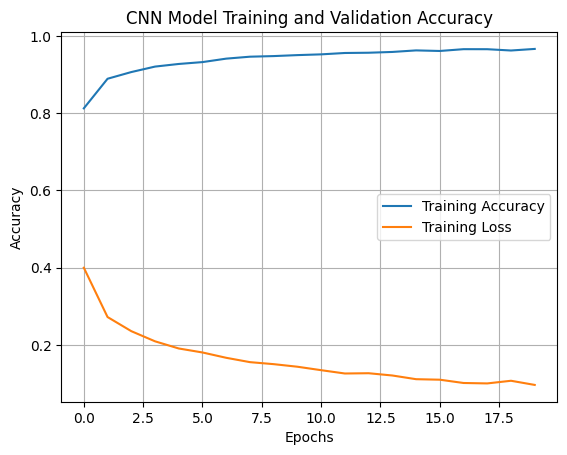

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save Model

In [ ]:
model.save('model_cnn_proper_apps_v2.h5', save_format='h5')

In [ ]:
var_mapping_path = 'Dataset/Variable Mapping V3.xlsx'

var_mapping = pd.read_excel(os.path.join(drive_path, var_mapping_path))
var_mapping['group'] = var_mapping['group'].replace({'Dieta2': 'Dieta1'})
var_mapping['model_var_name'] = var_mapping['group'] + "_" + var_mapping['variable']

model_var = pd.DataFrame({'model_var_name': df_raw.columns.tolist()})

model_var = pd.merge(model_var, var_mapping, left_on=model_var['model_var_name'].str.lower(), right_on=var_mapping['model_var_name'].str.lower(), how='outer', indicator=True).query('_merge!="right_only"')

# To Check if all variable is tagged
# model_var[model_var['_merge'] == "left_only"]

model_var = model_var[['model_var_name_x', 'lifestyle', 'desc']].rename(columns={'model_var_name_x': 'model_var_name'}).drop_duplicates().reset_index(drop=True)

model_var

,model_var_name,lifestyle,desc
0,Quest22_SMQ890,False,Ever Smoked A Cigar Even 1 Time?
1,Quest22_SMQ900,False,Ever Used An E-Cigarette?
2,Quest21_SLQ300,True,Usual Sleep Time On Weekdays Or \nWorkdays
3,Quest21_SLQ330,True,Usual Wake Time On Weekends
4,Quest21_SLD012,True,Sleep Hours - Weekdays Or \nWorkdays
5,Dieta1_DR1TKCAL,True,Energy (Kcal)
6,Dieta1_DR1TPROT,True,Protein (Gm)
7,Dieta1_DR1TCARB,True,Carbohydrate (Gm)
8,Dieta1_DR1TSUGR,True,Total Sugars (Gm)
9,Dieta1_DR1TFIBE,True,Dietary Fiber (Gm)


In [ ]:
model_var.loc[model_var['lifestyle'].isna(), 'lifestyle'] = True
model_var.loc[model_var['desc'].isna(), 'desc'] = 'Minutes of Vigorous Activity'

In [ ]:
model_var[model_var['lifestyle'] == True].shape

(16, 3)

In [ ]:
model_var.set_index('model_var_name').loc[[col for col in sorted(df_raw.columns.tolist()) if "Dieta" in col]]

,lifestyle,desc
model_var_name,,
Dieta1_DR1TCALC,True,Calcium (Mg)
Dieta1_DR1TCARB,True,Carbohydrate (Gm)
Dieta1_DR1TCHOL,True,Cholesterol (Mg)
Dieta1_DR1TFIBE,True,Dietary Fiber (Gm)
Dieta1_DR1TKCAL,True,Energy (Kcal)
Dieta1_DR1TMFAT,True,Total Monounsaturated Fatty Acids (Gm)
Dieta1_DR1TPFAT,True,Total Polyunsaturated Fatty Acids (Gm)
Dieta1_DR1TPROT,True,Protein (Gm)
Dieta1_DR1TSFAT,True,Total Saturated Fatty Acids (Gm)


In [ ]:
df_raw['Quest3_CDQ008'].value_counts()

Quest3_CDQ008
9.0    4437
2.0     857
1.0     275
Name: count, dtype: int64

In [ ]:
import json

# generate lifestyle description
json_obj = {}
for col, desc in model_var[model_var['lifestyle']==True][['model_var_name', 'desc']].values:
    json_obj[col]=desc

with open('v1_lifestyle_description.json', 'w') as json_file:
    json.dump(json_obj, json_file)

# generate columns order
column_order = {'lifestyle': {}, 'characteristic': {}}
sampling = df_raw.sample(n=1, axis=0)

for index, key in enumerate(sampling.columns.tolist()):
    if index < model_var[model_var['lifestyle']==True].shape[0]:
        column_order['lifestyle'][key] = index
    else:
        column_order['characteristic'][key] = index

with open('v1_columns_order.json', 'w') as json_file:
    json.dump(column_order, json_file)

In [ ]:
list(df_raw[df_raw['Quest3_CDQ008'] == 1].sample(1).values)

[array([  2. ,   2. ,   2. ,   2. ,   3. ,   2. ,   1. ,   2. ,   2. ,
          1. ,   2. ,   2. ,   2. ,   2. ,   2. ,   2. ,   0. ,  66. ,
         94.6, 161.8,  36.1,   1. ,  78. ,  78. ,   2. ])]

In [ ]:
list(df_raw[df_raw['Quest3_CDQ008'] == 1].sample(1))

['Quest22_SMQ890',
 'Quest22_SMQ900',
 'Quest21_SLQ300',
 'Quest21_SLQ330',
 'Quest21_SLD012',
 'Dieta1_DR1TKCAL',
 'Dieta1_DR1TPROT',
 'Dieta1_DR1TCARB',
 'Dieta1_DR1TSUGR',
 'Dieta1_DR1TFIBE',
 'Dieta1_DR1TTFAT',
 'Dieta1_DR1TSFAT',
 'Dieta1_DR1TMFAT',
 'Dieta1_DR1TPFAT',
 'Dieta1_DR1TCHOL',
 'Dieta1_DR1TCALC',
 'Quest19_VigorousActivity',
 'Demog1_RIDAGEYR',
 'Exami2_BMXWT',
 'Exami2_BMXHT',
 'Exami2_BMXBMI',
 'Quest3_CDQ008',
 'Exami1_SysPulse',
 'Exami1_DiaPulse',
 'Quest16_MCQ160B']